In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import seaborn as sns
import yaml

plt.rcParams['figure.dpi'] = 300

#### Import embeddings

In [49]:
folder = "AquaHkmLabSea2022b"
filepath = "/home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/"+folder

#filename = "embs.nc"
#filename = "embs_no_land.nc"
#filename = "embs_no_ice.nc" # This data also has no land
filename = "embs_cao.nc"

In [50]:
tiles_ds = xr.open_dataset(filepath+"/"+filename)
tiles_ds

<xarray.Dataset>
Dimensions:        (tile_type: 3, tile_id: 1380, emb_dim: 100)
Coordinates:
  * tile_id        (tile_id) int64 13 19 27 28 39 ... 9984 9992 9995 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 ...
    isomap_x       (tile_type, tile_id) float32 ...
    isomap_y       (tile_type, tile_id) float32 ...
    c_lat          (tile_type, tile_id) float32 ...
    c_lon          (tile_type, tile_id) float32 ...
    time           (tile_type, tile_id) datetime64[ns] ...
    land_fraction  (tile_type, tile_id) float32 ...
    cao            (tile_type, tile_id) float32 ...
    anchor_cao     (tile_id) float32 ...

#### Load ERA data and add to dataset if necessary

In [22]:
era_folder = "/home/eefjg/OneDrive/Leeds/PhD/Data/ERA5"
era_files = glob(era_folder + "/ERA5*.nc")

In [23]:
era_ds = xr.open_mfdataset(era_files, combine='by_coords')
era_ds

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 101, time: 365)
Coordinates:
  * longitude  (longitude) float32 -65.0 -64.75 -64.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2022-01-01T16:00:00 ... 2022-12-31T16:00:00
Data variables:
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    t          (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-20 14:55:23 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [24]:
# Calculate CAO index
# calculate surface theta
# calculate 800hPa theta

era_ds['theta_800'] = era_ds['t'] * (1000 / 800) ** 0.286
era_ds['theta_skt'] = era_ds['skt'] * (1000 / (era_ds['msl']/100)) ** 0.286
era_ds['cao'] = era_ds['theta_skt'] - era_ds['theta_800']
era_ds

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 101, time: 365)
Coordinates:
  * longitude  (longitude) float32 -65.0 -64.75 -64.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2022-01-01T16:00:00 ... 2022-12-31T16:00:00
Data variables:
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    t          (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    theta_800  (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    theta_skt  (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    cao        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-20 14:55:23 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [61]:
# for each tile, find the nearest era5 grid point and extract era5 variables~

era_variables = ['siconc']

for v in era_variables:
    tiles_ds[v] = xr.full_like(tiles_ds['isomap_x'], fill_value=np.nan)

In [62]:
era_ds.load()


for tile_id in tqdm(tiles_ds.tile_id):
    for tile_type in ['anchor', 'neighbor', 'distant']:
        lat = tiles_ds["c_lat"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        lon = tiles_ds["c_lon"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        time = tiles_ds["time"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        
        era_ds_tile = era_ds.sel(latitude=lat, longitude=lon, time=time, method='nearest')
        
        for v in era_variables:
            tiles_ds[v].loc[dict(tile_id=tile_id, tile_type=tile_type)] = era_ds_tile[v]

100%|██████████| 1380/1380 [00:09<00:00, 146.78it/s]


In [63]:
tiles_ds

<xarray.Dataset>
Dimensions:        (tile_type: 3, tile_id: 1380, emb_dim: 100)
Coordinates:
  * tile_id        (tile_id) int64 13 19 27 28 39 ... 9984 9992 9995 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 ...
    isomap_x       (tile_type, tile_id) float32 -0.6771 0.7803 ... -1.205 -1.022
    isomap_y       (tile_type, tile_id) float32 -0.1463 -0.2812 ... 0.2508
    c_lat          (tile_type, tile_id) float32 ...
    c_lon          (tile_type, tile_id) float32 ...
    time           (tile_type, tile_id) datetime64[ns] ...
    land_fraction  (tile_type, tile_id) float32 0.0 0.0 0.0 ... 0.0 1.0 0.6611
    cao            (tile_type, tile_id) float32 8.114 3.033 ... -21.99 -12.56
    anchor_cao     (tile_id) float32 ...
    siconc         (tile_type, tile_id) float32 0.0 0.0 0.0 0.0 ... 0.0 nan nan

In [28]:
tiles_ds.cao.mean()

<xarray.DataArray 'cao' ()>
array(-8.482442, dtype=float32)

### Plot heatmaps on manifold dimensions

In [64]:
# convert isomap coords and variables of interest to a pd dataframe for binning and plotting

variables = ['land_fraction', 'cao', 'siconc']

tiles_df = tiles_ds[['isomap_x','isomap_y']+ variables].to_dataframe()
tiles_df.head()

isomap_x  isomap_y  land_fraction       cao  siconc
tile_type tile_id                                                     
anchor    13      -0.677060 -0.146310            0.0  8.114288     0.0
          19       0.780341 -0.281152            0.0  3.033417     0.0
          27      -0.725291 -0.007819            0.0  7.236145     0.0
          28      -0.762106  0.067148            0.0  2.166779     0.0
          39       0.964685  0.052211            0.0  2.878387     0.0

In [65]:
print("xmax: ", tiles_df['isomap_x'].max())
print("xmin: ", tiles_df['isomap_x'].min())
print("ymax: ", tiles_df['isomap_y'].max())
print("ymin: ", tiles_df['isomap_y'].min())

xmax:  1.4794765710830688
xmin:  -1.2727324962615967
ymax:  0.9483730792999268
ymin:  -0.9802443385124207


In [66]:
# define bins for isomap x and y, based on max and min values of isomap coordinates

# x_bins = np.linspace(-1, 2, 61)
# y_bins = np.linspace(-1, 2, 61)

# x_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.975, 1.975, 60)]
# y_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.975, 1.975, 60)]


x_bins = np.linspace(-1, 2, 31)
y_bins = np.linspace(-1, 2, 31)

x_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.95, 1.95, 30)]
y_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.95, 1.95, 30)]

In [67]:
# bin the data based on isomap coordinates

tiles_df['isomap_x_bin'] = pd.cut(tiles_df['isomap_x'], bins=x_bins, labels=x_bin_labels)
tiles_df['isomap_y_bin'] = pd.cut(tiles_df['isomap_y'], bins=y_bins, labels=y_bin_labels)
tiles_df.head()

isomap_x  isomap_y  land_fraction       cao  siconc  \
tile_type tile_id                                                        
anchor    13      -0.677060 -0.146310            0.0  8.114288     0.0   
          19       0.780341 -0.281152            0.0  3.033417     0.0   
          27      -0.725291 -0.007819            0.0  7.236145     0.0   
          28      -0.762106  0.067148            0.0  2.166779     0.0   
          39       0.964685  0.052211            0.0  2.878387     0.0   

                  isomap_x_bin isomap_y_bin  
tile_type tile_id                            
anchor    13             -0.65        -0.15  
          19              0.75        -0.25  
          27             -0.75        -0.05  
          28             -0.75         0.05  
          39              0.95         0.05

In [68]:
# find the mean of a given variable in each bin

def bin_means(df, var):
    means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)
    means = means.iloc[::-1]    # flip the dataframe so that the y axis is increasing upwards
    return means

In [69]:
# plot heatmap of bin means

def plot_means(means_df, cmap, title, center=None, vmin=None):
    fig = sns.heatmap(means_df, cmap=cmap, center=center, vmin=vmin)
    fig.title.set_text(title)
    fig.set_xlabel('Isomap x', fontsize=10)
    fig.set_ylabel('Isomap y', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    return fig

/tmp/ipykernel_32690/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


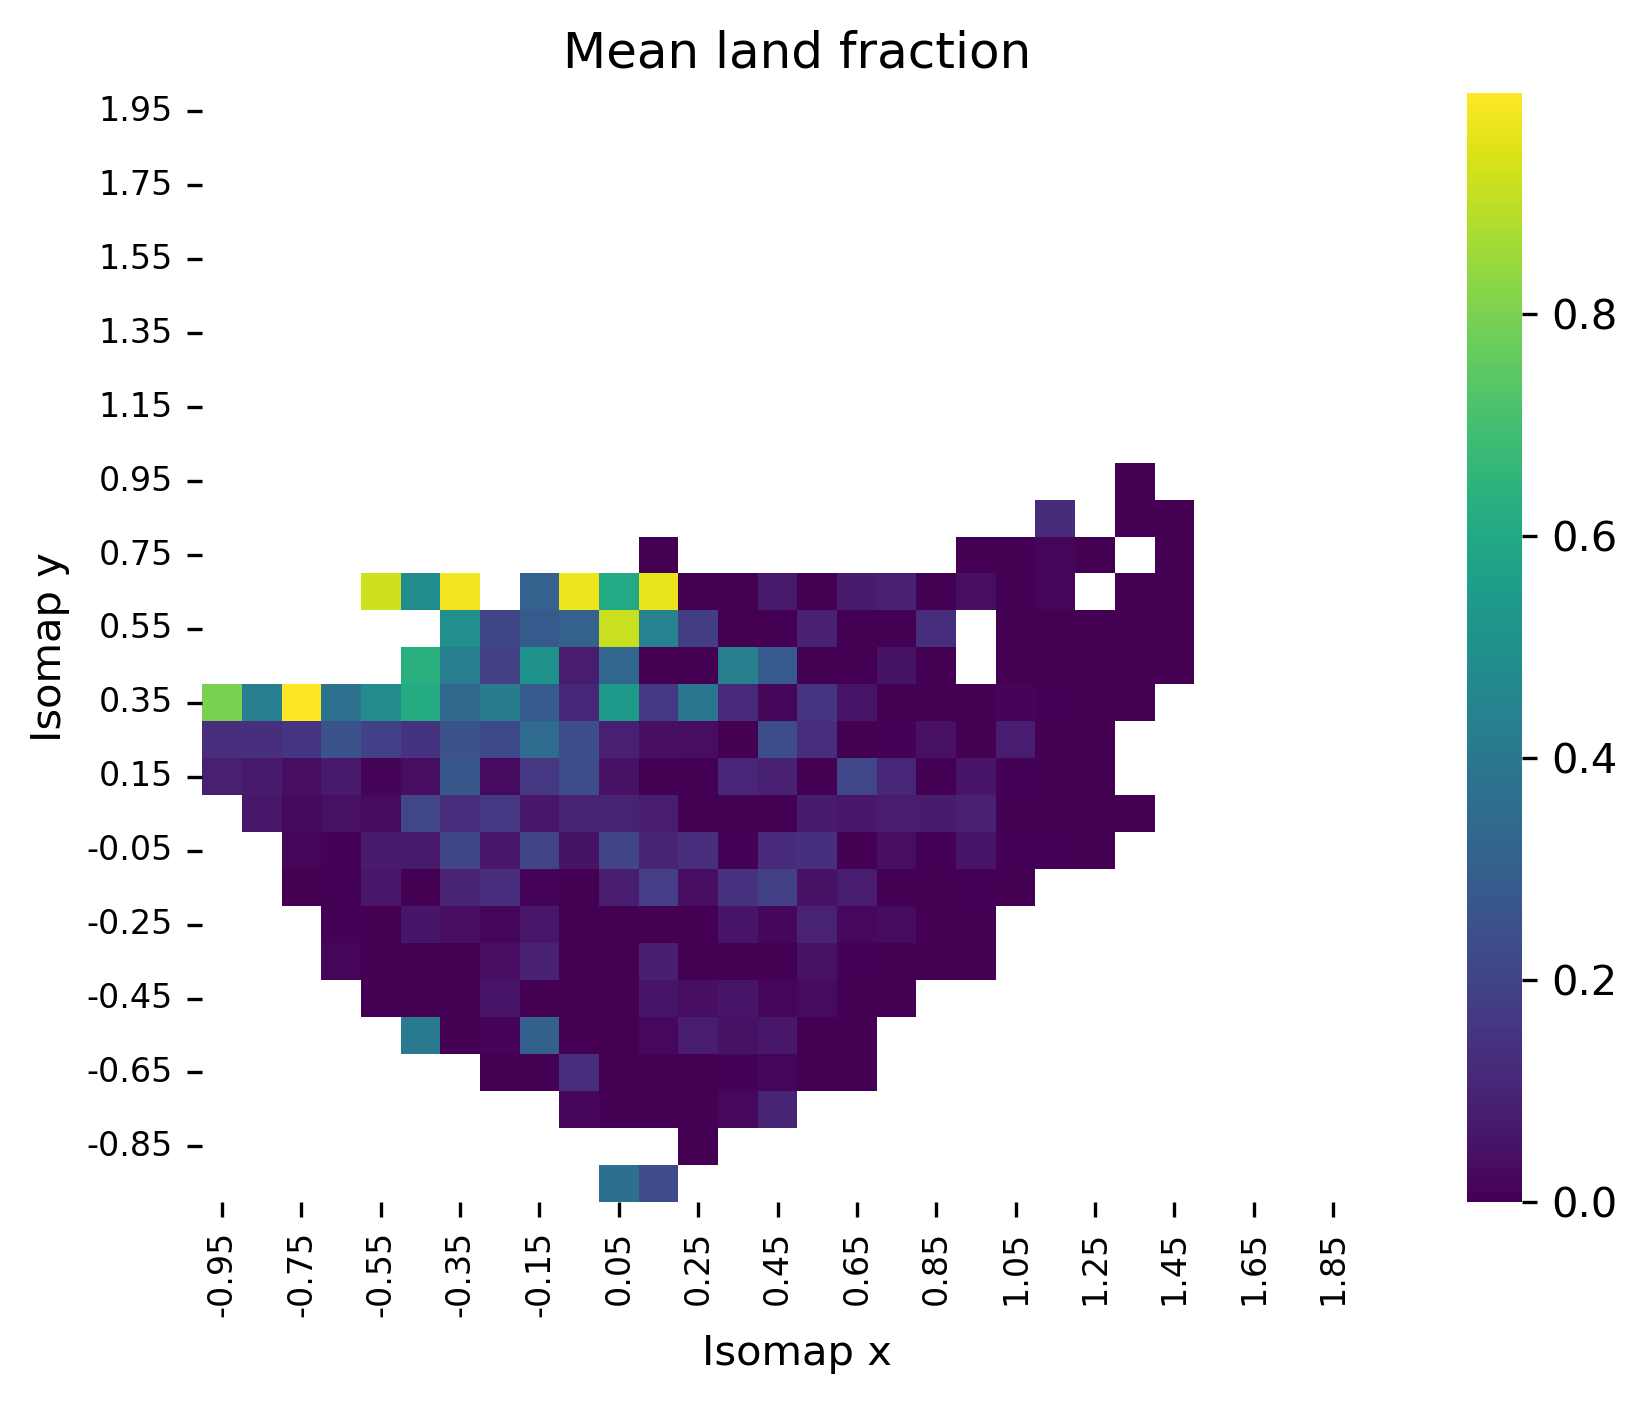

In [70]:
lf_means = bin_means(tiles_df, 'land_fraction')
plot_means(lf_means, 'viridis', 'Mean land fraction');

/tmp/ipykernel_32690/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


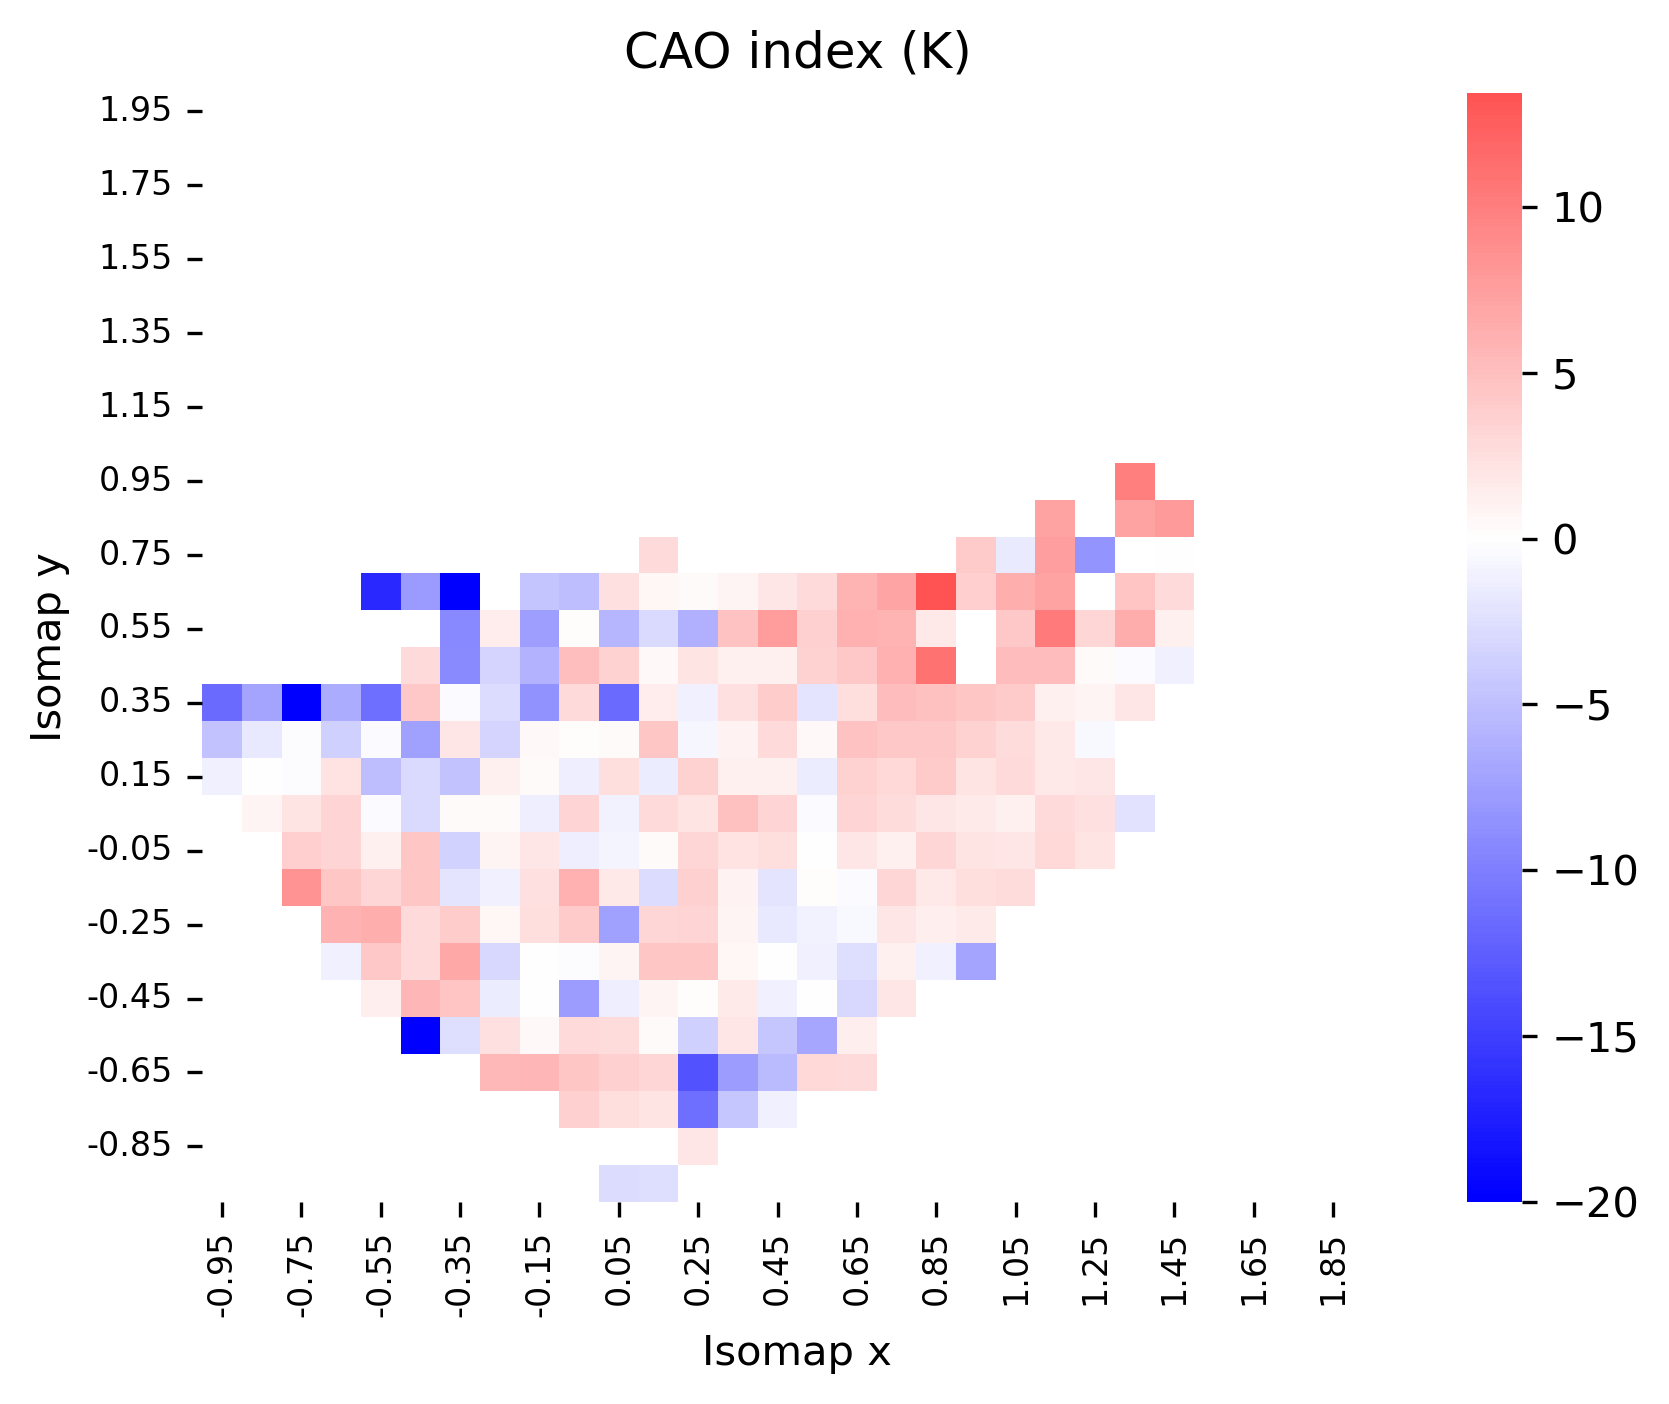

In [71]:
cao_means = bin_means(tiles_df, 'cao')
plot_means(cao_means, 'bwr', 'CAO index (K)', center=0, vmin=-20);

/tmp/ipykernel_32690/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


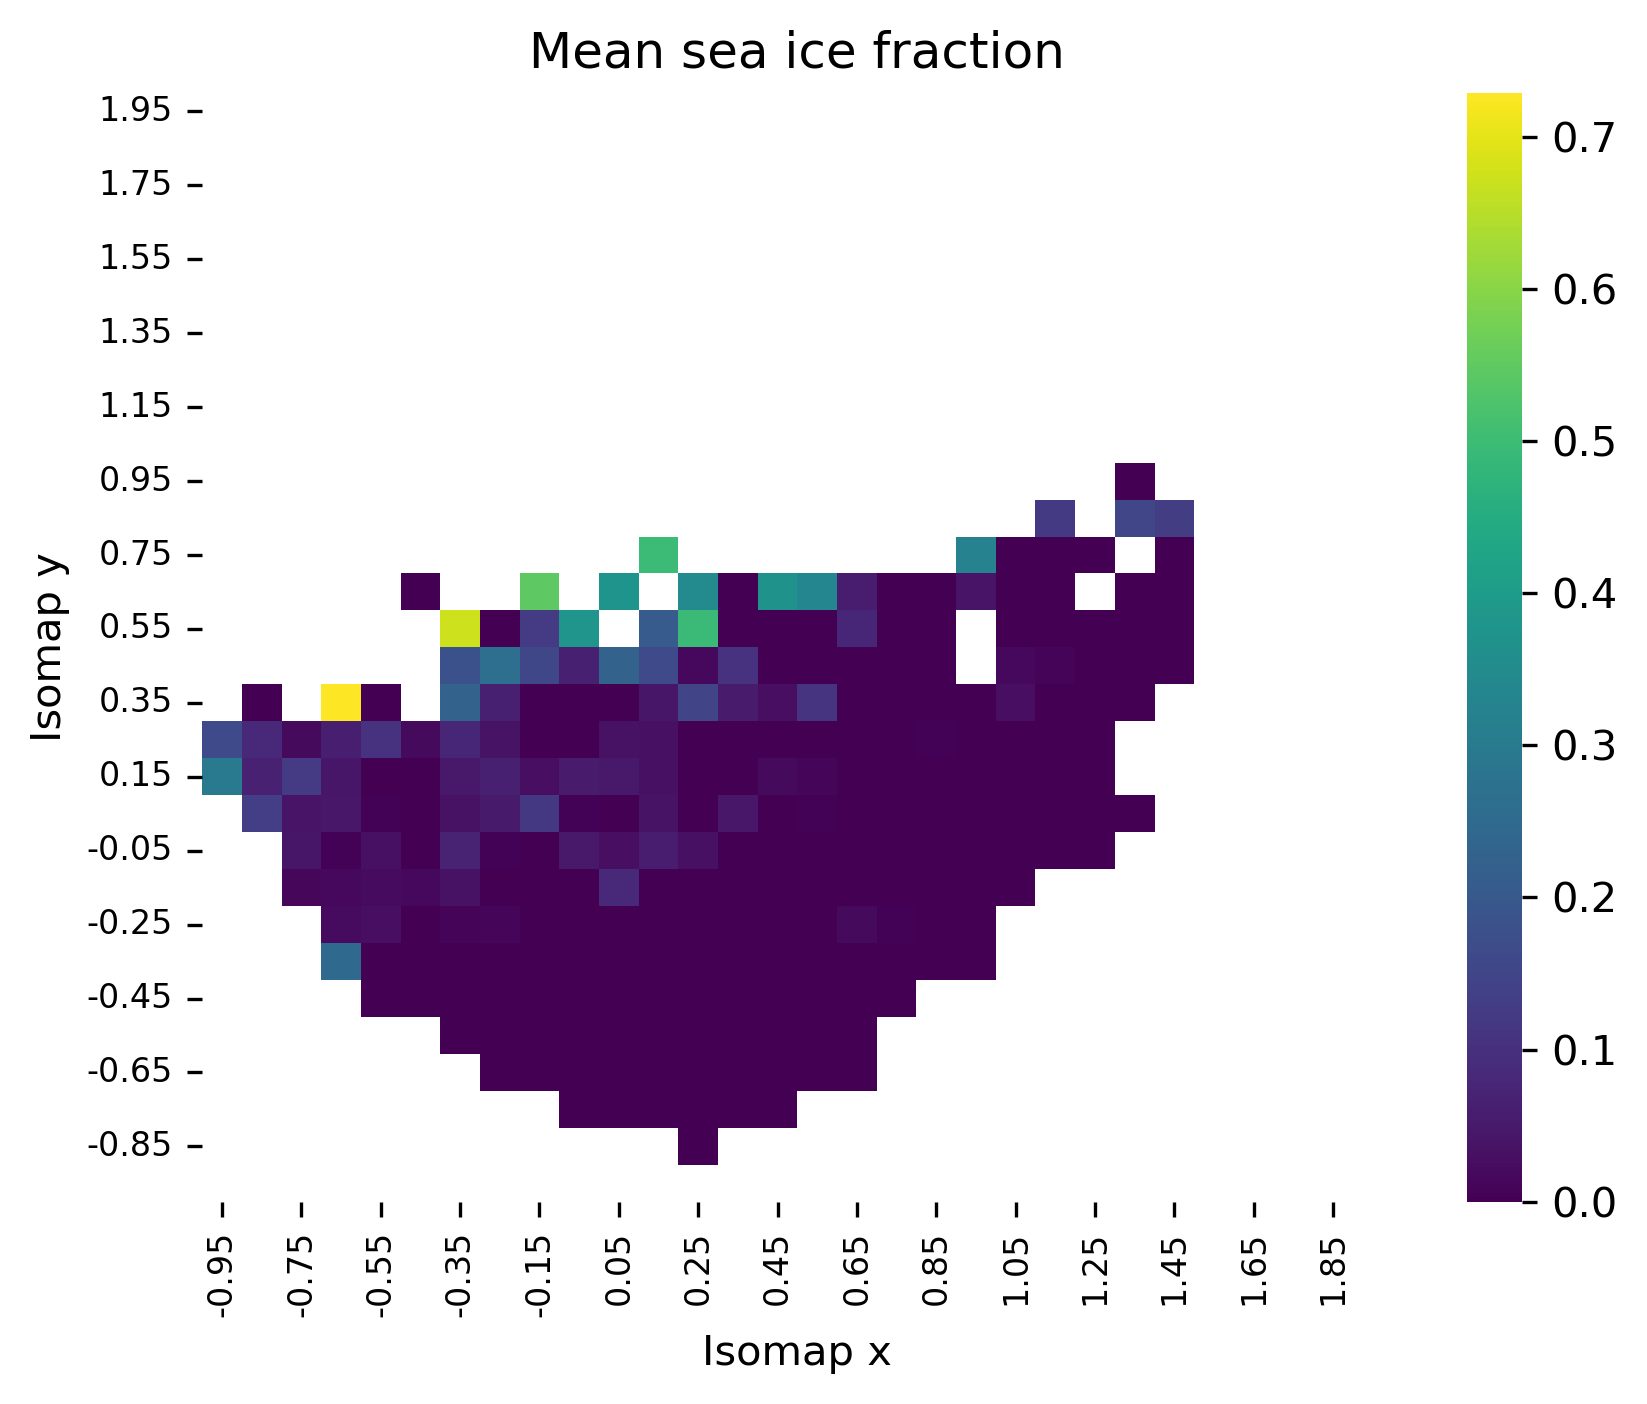

In [72]:
si_means = bin_means(tiles_df, 'siconc')
plot_means(si_means, 'viridis', 'Mean sea ice fraction');

/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


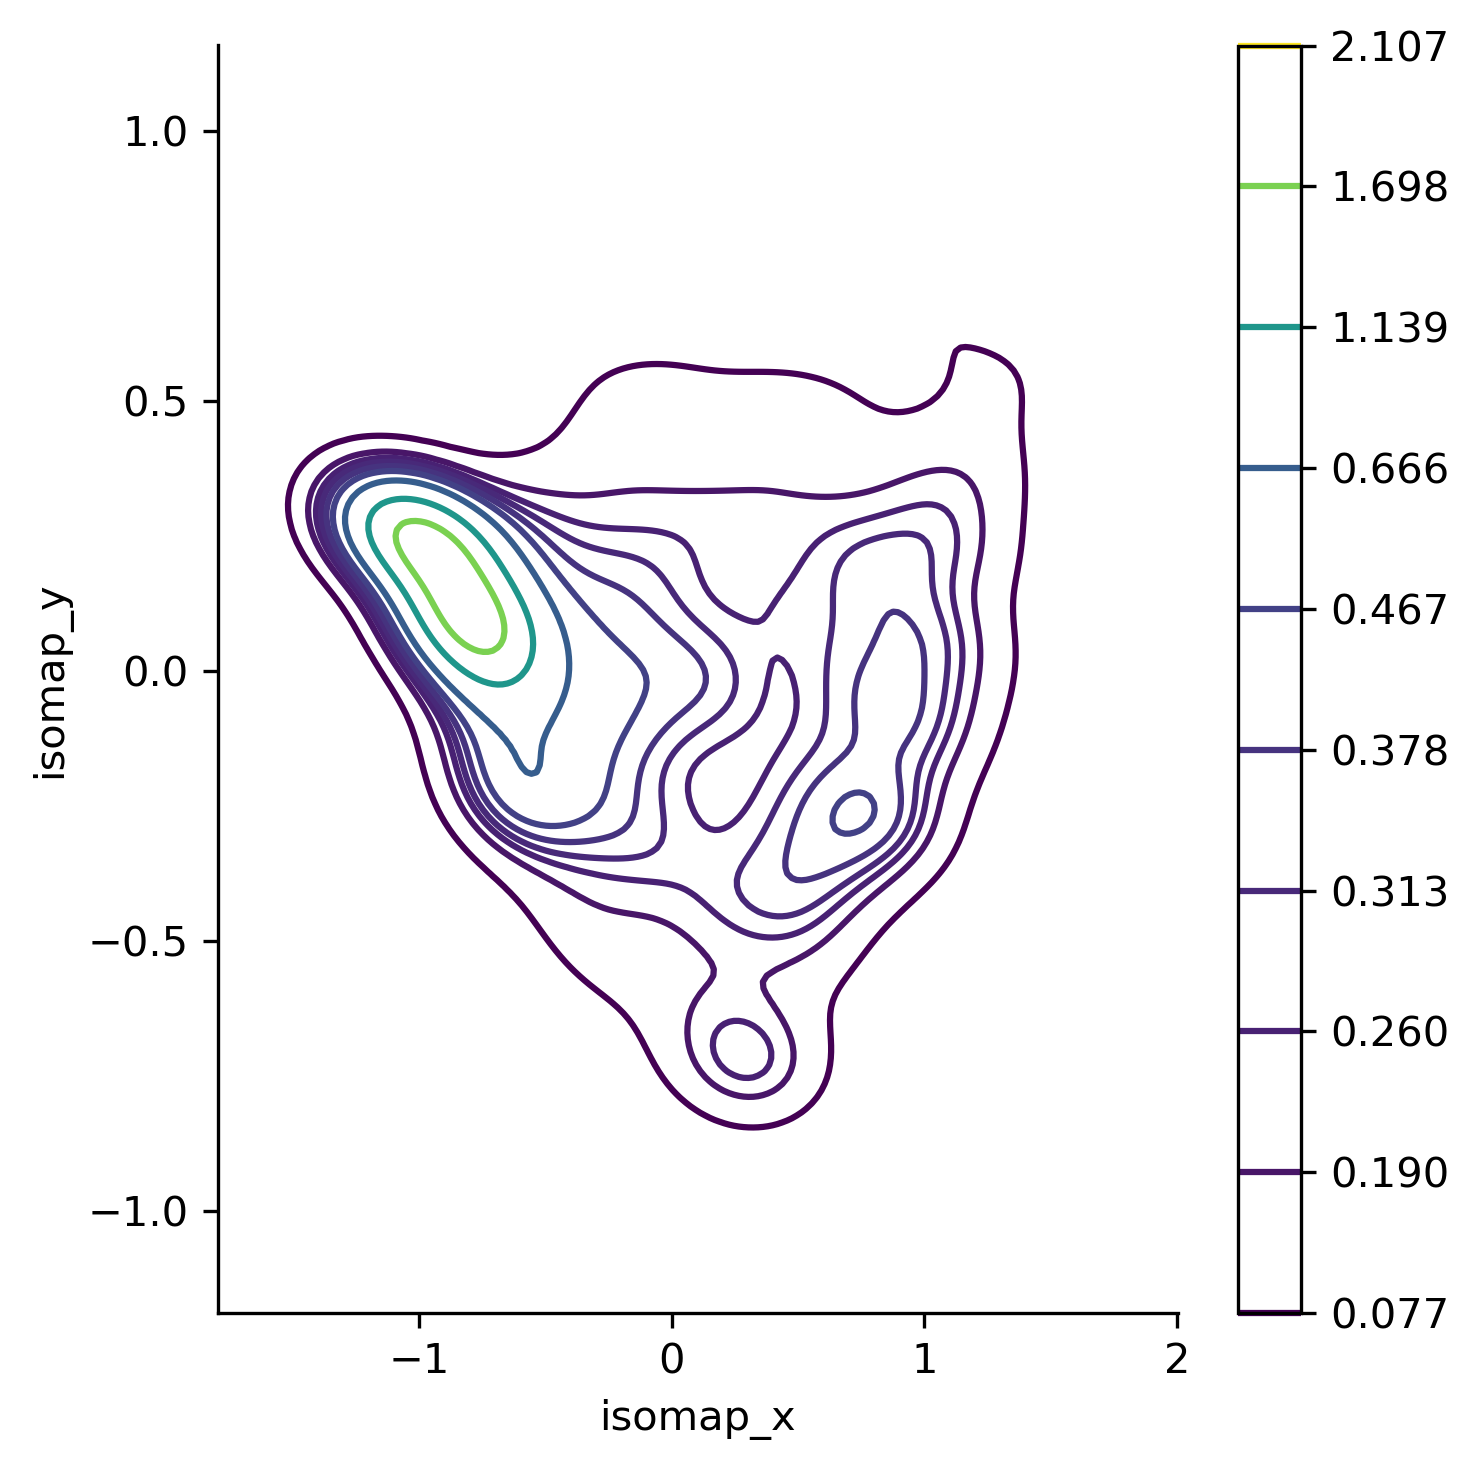

In [73]:
sns.displot(tiles_df, x='isomap_x', y='isomap_y', cmap='viridis', cbar=True, kind='kde', levels=10)